# The Deep Learning Homework 3 - Question No. 10 Part A
Bahar Mahdavi - SN: 40152521337

## A. Training network on the MNIST dataset for 15 epochs, with the Cross Entropy loss function and compare batch sizes of 1, 8, 32 and 50 and the memory consumption (GPU/CPU) and the execution speed.

Network architecture:

layer1: Conv2d(in-channels=1, out-channels=16, kernel-size=3, padding=1) , ReLU , MaxPool2d(kernel-size=2,stride=2)

layer2: Conv2d(in-channels=16, out-channels=32, kernel-size=3, padding=1) , ReLU , MaxPool2d(kernel-size=2,stride=2)

flatten: view(-1, ?)

layer3: linear(? to 1024), ReLU , dropout

layer4: linear(1024 to 10) , log-softmax #Because log-softmax active function has cross-entropy inside itself, we use active function Softmax(dim = 1) instead

### Setting up the Environment

In [ ]:
import torch
x=torch.tensor([1]).to('cuda')
print(torch.cuda.is_available())
# moves your model to train on your gpu if available else it uses your cpu
device = ("cuda" if torch.cuda.is_available() else "cpu")

#torch.random_seed()
#torch.manual_seed(17)

True


### Load MNIST Dataset from TorchVision

In [ ]:
from torchvision import datasets, transforms

# Define transform to normalize data
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,))
                                ])

# Download and load the training data
train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transforms.ToTensor())
trainLoader_1 = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True)
trainLoader_8 = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
trainLoader_32 = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
trainLoader_50 = torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True)

test_set = datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=transforms.ToTensor())
testLoader_1 = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
testLoader_8 = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=True)
testLoader_32 = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)
testLoader_50 = torch.utils.data.DataLoader(test_set, batch_size=50, shuffle=True)

In [ ]:
training_data = enumerate(trainLoader_50) # 1, 8, 32, 50
batch_idx, (images, labels) = next(training_data)
print(type(images)) # Checking the datatype
print(images.shape) # the size of the image
print(labels.shape) # the size of the labels

<class 'torch.Tensor'>
torch.Size([50, 1, 28, 28])
torch.Size([50])


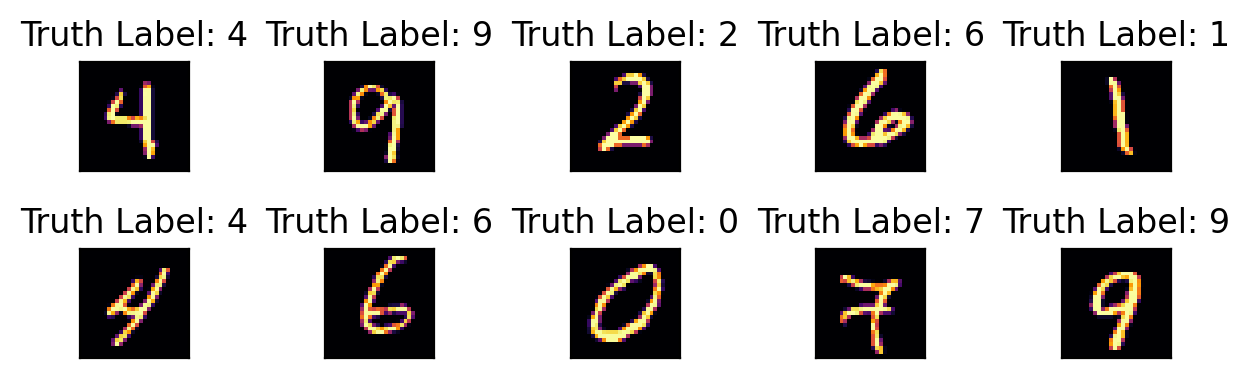

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#import helper
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

fig = plt.figure()
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.tight_layout()
    plt.imshow(images[i][0], cmap='inferno')
    plt.title("Truth Label: {}".format(labels[i]))
    plt.yticks([])
    plt.xticks([])

### Building the Network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MnistModel(nn.Module):

    def __init__(self):
        super(MnistModel, self).__init__()
        # Convolutional Neural Network Layer
        self.convolutaional_neural_network_layers = nn.Sequential(
                # Here we are defining our 2D convolutional layers
                # We can calculate the output size of each convolutional layer using the following formular:
                # outputOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1
                # We have in_channels=1 because our input is a grayscale image
                # input is 28x28x1
                # padding=2 for same padding
                nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1), # (N, 1, 28, 28)
                nn.ReLU(),
                # After the first convolutional layer the output of this layer is:
                # [(28 + 2*1 - 3)/1] + 1 = 28.
                nn.MaxPool2d(kernel_size=2, stride=2),
                # Since we applied maxpooling with kernel_size=2 we have to divide by 2, so we get:
                # 28 / 2 = 14
                # output of our second conv layer
                # feature map size is 14*14*16 by pooling
                # padding=2 for same padding
                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                # After the second convolutional layer the output of this layer is:
                # [(14 + 2*1 - 3)/1] + 1 = 14.
                nn.MaxPool2d(kernel_size=2)
                # Since we applied maxpooling with kernel_size=2 we have to divide by 2, so we get
                # 14 / 2 = 7
        )
        # Linear layer
        self.linear_layers = nn.Sequential(
                # We have the output_channel=32 of our second conv layer, and 7*7 is derived by the formular
                # which is the output of each convolutional layer
                # feature map size is 7*7*32 by pooling
                nn.Linear(in_features=32*7*7, out_features=1024),
                nn.ReLU(),
                nn.Dropout(p=0.2), # Dropout with probability of 0.2 to avoid overfitting
                nn.Linear(in_features=1024, out_features=10), # The output is 10 which should match the size of our class
                nn.Softmax(dim = 1)
        )
          # Defining the forward pass
    def forward(self, x):
        x = self.convolutaional_neural_network_layers(x)
        # After we get the output of our convolutional layer we must flatten it or rearrange the output into a vector
        x = x.view(-1, 32*7*7)   # reshape Variable
        # Then pass it through the linear layer
        x = self.linear_layers(x)
        return x

In [ ]:
model = MnistModel()
model.to(device)

MnistModel(
  (convolutaional_neural_network_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1568, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)

### Specify Loss Function and Optimizer

In [ ]:
from torch import optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

### Training and Testing the Model with 50 batch_size

In [ ]:
epochs = 15
train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_val = [], []

for epoch in range(epochs):

    total_train_loss = 0
    total_val_loss = 0

    model.train()

    total = 0
    # training our model
    for idx, (image, label) in enumerate(trainLoader_50): # 1, 8, 32, 50

        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()    # calc gradients
        optimizer.step()   # update gradients

        #pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_train = total / len(train_set)
    accuracy_total_train.append(accuracy_train)

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)

    # validating our model
    model.eval()
    total = 0
    for idx, (image, label) in enumerate(testLoader_50): # 1, 8, 32, 50
        image, label = image.cuda(), label.cuda()
        pred = model(image)
        loss = criterion(pred, label)
        total_val_loss += loss.item()

        #pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_val = total / len(test_set)
    accuracy_total_val.append(accuracy_val)

    total_val_loss = total_val_loss / (idx + 1)
    val_loss.append(total_val_loss)

    if epoch % 5 == 0:
      print("Epoch: {}/{}  ".format(epoch, epochs),
            "Training loss: {:.4f}  ".format(total_train_loss),
            "Testing loss: {:.4f}  ".format(total_val_loss),
            "Train accuracy: {:.4f}  ".format(accuracy_train),
            "Test accuracy: {:.4f}  ".format(accuracy_val))

Epoch: 0/15   Training loss: 1.6617   Testing loss: 1.5366   Train accuracy: 0.8354   Test accuracy: 0.9325  
Epoch: 5/15   Training loss: 1.4876   Testing loss: 1.4826   Train accuracy: 0.9763   Test accuracy: 0.9808  
Epoch: 10/15   Training loss: 1.4757   Testing loss: 1.4765   Train accuracy: 0.9871   Test accuracy: 0.9865  


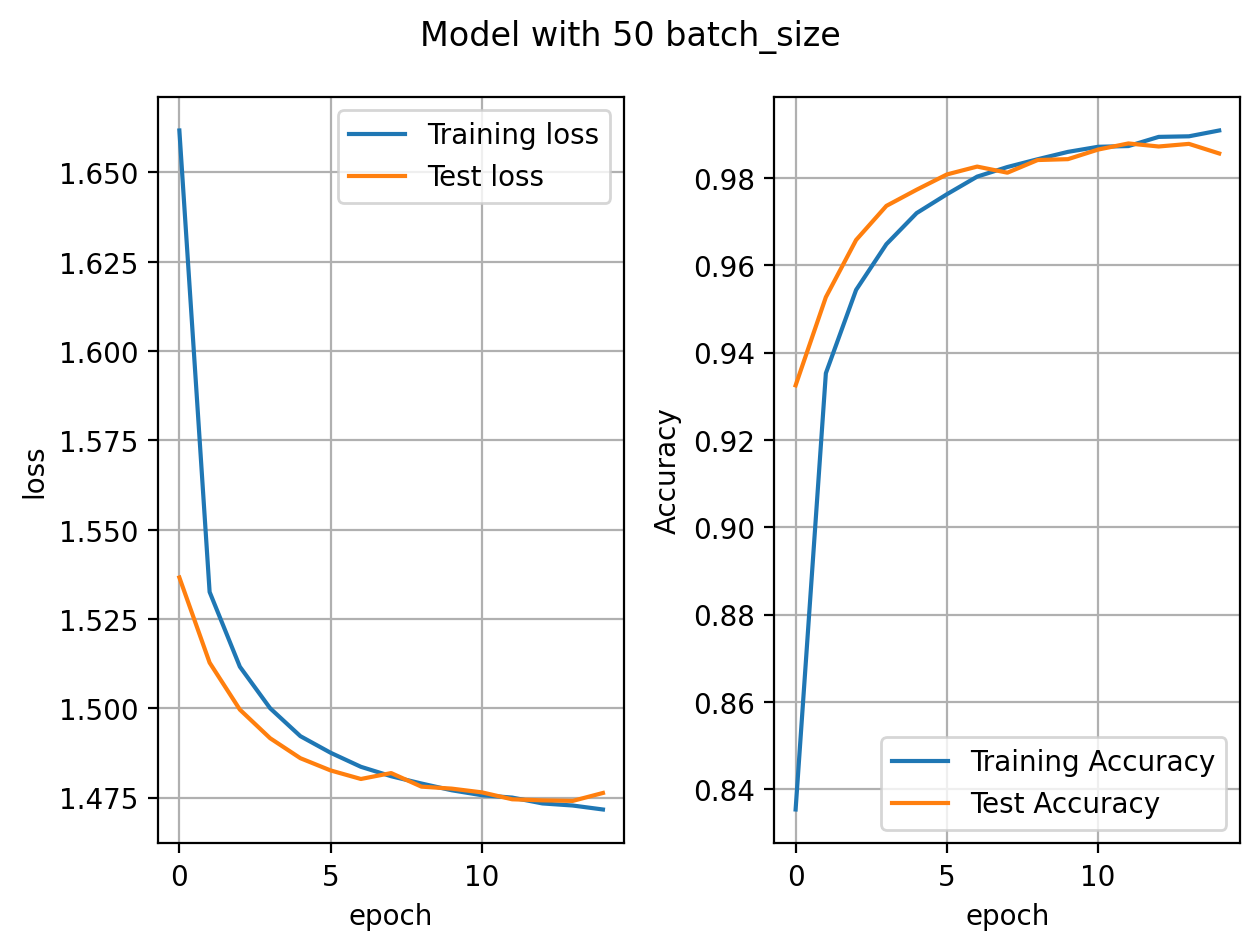

In [ ]:
plt.subplot(1,2,1)
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(accuracy_total_train, label='Training Accuracy')
plt.plot(accuracy_total_val, label='Test Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.suptitle(f'Model with 50 batch_size')
plt.tight_layout()
plt.show()

### Evaluating the Network Model with 50 batch_size

In [ ]:
img = images[0]
img = img.to(device)
img = img.view(-1, 1, 28, 28)
print(img.shape)

# Since we want to use the already pretrained weights to make some prediction
# we are turning off the gradients
with torch.no_grad():
    logits = model.forward(img)

torch.Size([1, 1, 28, 28])


[0.08533674 0.08533674 0.08533675 0.08533674 0.08533674 0.08533674
 0.08533674 0.23196927 0.08533674 0.08533674]


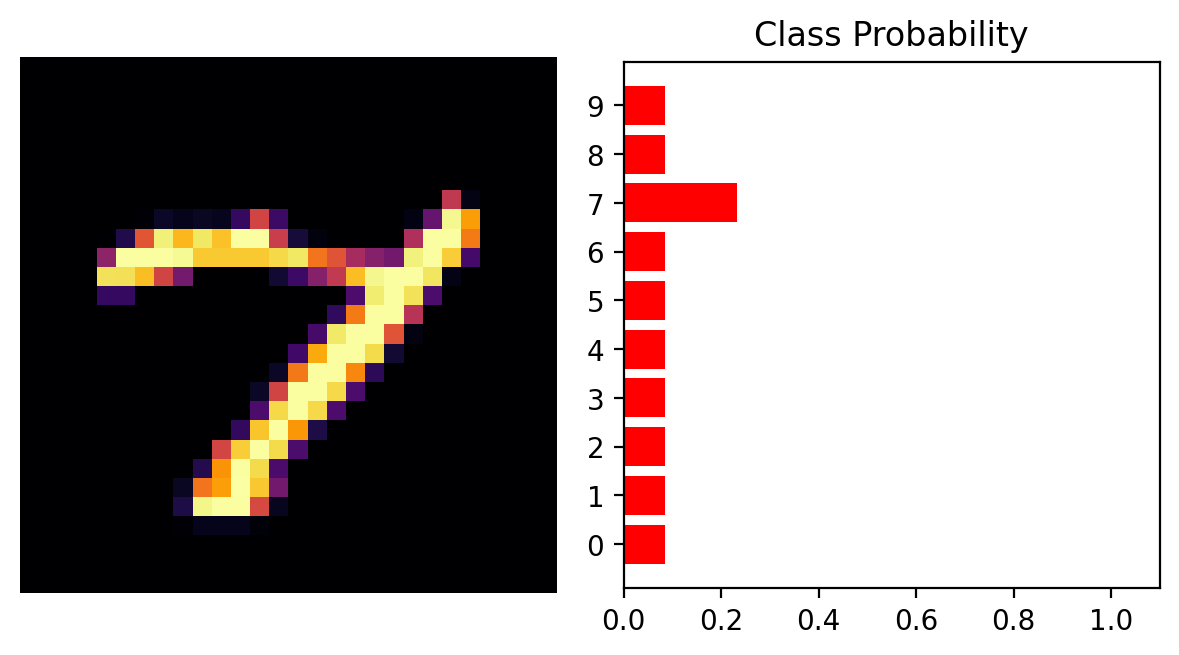

In [ ]:
#We take the softmax for probabilites since our outputs are logits
probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
ax1.imshow(img.view(1, 28, 28).detach().cpu().numpy().squeeze(), cmap='inferno')
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()

### Training and Testing the Model with 32 batch_size

In [ ]:
epochs = 15
train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_val = [], []

for epoch in range(epochs):

    total_train_loss = 0
    total_val_loss = 0

    model.train()

    total = 0
    # training our model
    for idx, (image, label) in enumerate(trainLoader_32): # 1, 8, 32, 50

        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()    # calc gradients
        optimizer.step()   # update gradients

        #pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_train = total / len(train_set)
    accuracy_total_train.append(accuracy_train)

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)

    # validating our model
    model.eval()
    total = 0
    for idx, (image, label) in enumerate(testLoader_32): # 1, 8, 32, 50
        image, label = image.cuda(), label.cuda()
        pred = model(image)
        loss = criterion(pred, label)
        total_val_loss += loss.item()

        #pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_val = total / len(test_set)
    accuracy_total_val.append(accuracy_val)

    total_val_loss = total_val_loss / (idx + 1)
    val_loss.append(total_val_loss)

    if epoch % 5 == 0:
      print("Epoch: {}/{}  ".format(epoch, epochs),
            "Training loss: {:.4f}  ".format(total_train_loss),
            "Testing loss: {:.4f}  ".format(total_val_loss),
            "Train accuracy: {:.4f}  ".format(accuracy_train),
            "Test accuracy: {:.4f}  ".format(accuracy_val))

Epoch: 0/15   Training loss: 1.6363   Testing loss: 1.5226   Train accuracy: 0.8543   Test accuracy: 0.9473  
Epoch: 5/15   Training loss: 1.4802   Testing loss: 1.4777   Train accuracy: 0.9834   Test accuracy: 0.9857  
Epoch: 10/15   Training loss: 1.4723   Testing loss: 1.4748   Train accuracy: 0.9899   Test accuracy: 0.9868  


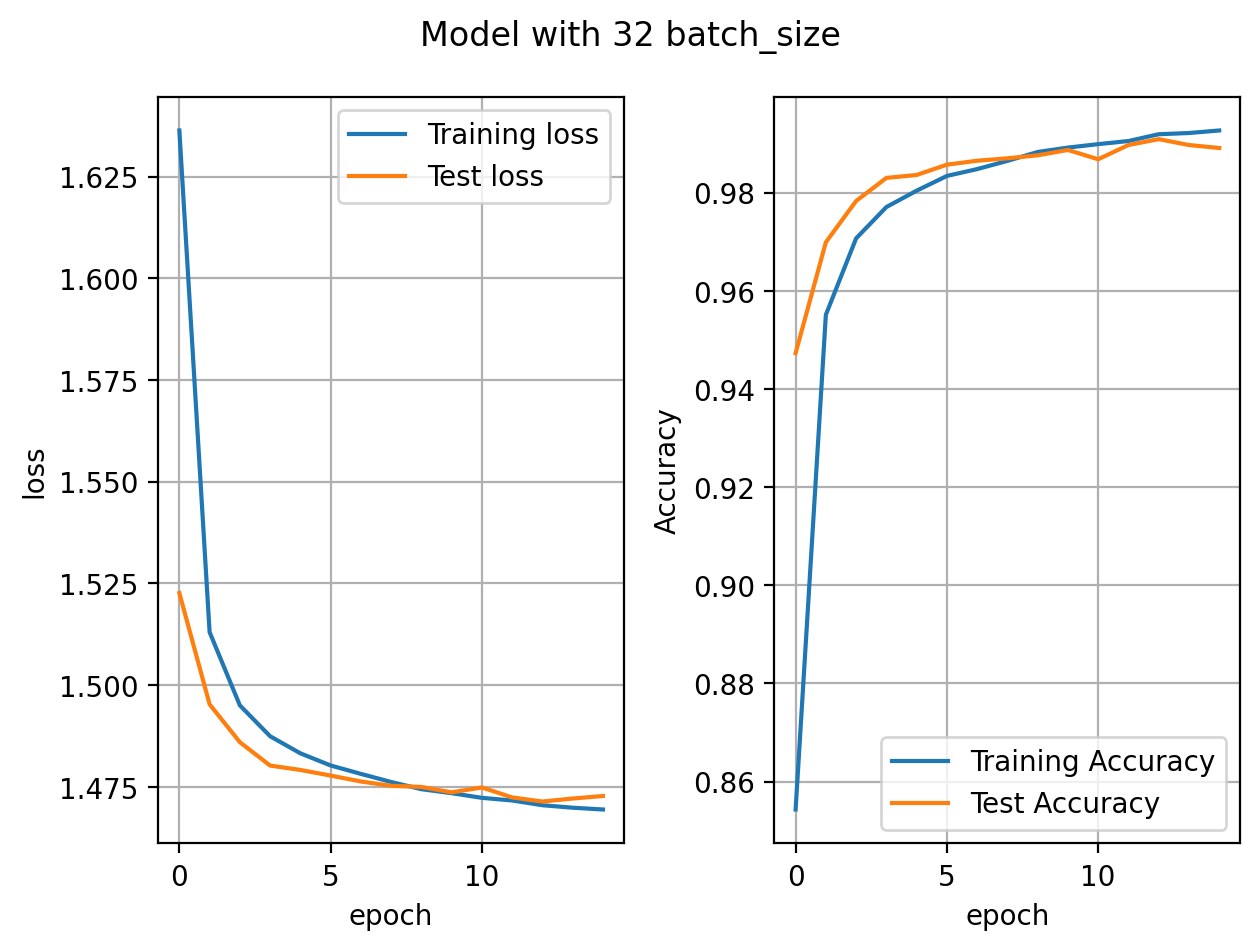

In [ ]:
plt.subplot(1,2,1)
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(accuracy_total_train, label='Training Accuracy')
plt.plot(accuracy_total_val, label='Test Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.suptitle(f'Model with 32 batch_size')
plt.tight_layout()
plt.show()

### Evaluating the Network Model with 32 batch_size

In [ ]:
img = images[0]
img = img.to(device)
img = img.view(-1, 1, 28, 28)
print(img.shape)

# Since we want to use the already pretrained weights to make some prediction
# we are turning off the gradients
with torch.no_grad():
    logits = model.forward(img)

torch.Size([1, 1, 28, 28])


[0.08533674 0.08533674 0.08533674 0.08533674 0.2319693  0.08533674
 0.08533674 0.08533674 0.08533674 0.08533674]


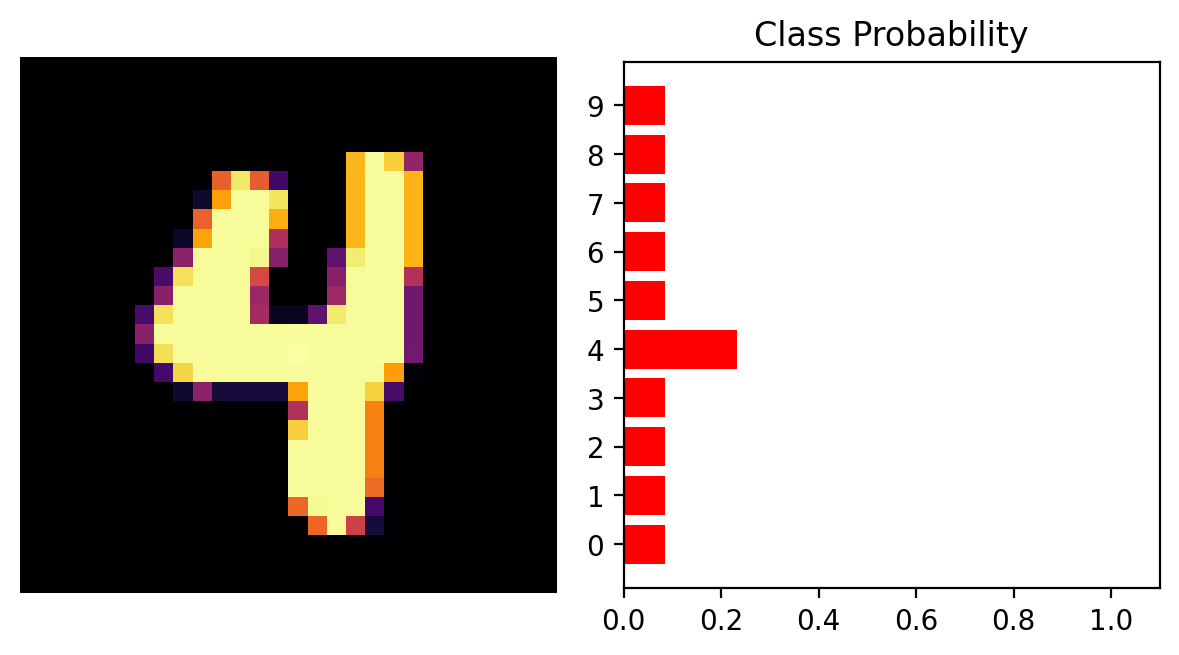

In [ ]:
#We take the softmax for probabilites since our outputs are logits
probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
ax1.imshow(img.view(1, 28, 28).detach().cpu().numpy().squeeze(), cmap='inferno')
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()

### Training and Testing the Model with 8 batch_size

In [ ]:
epochs = 15
train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_val = [], []

for epoch in range(epochs):

    total_train_loss = 0
    total_val_loss = 0

    model.train()

    total = 0
    # training our model
    for idx, (image, label) in enumerate(trainLoader_8): # 1, 8, 32, 50

        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()    # calc gradients
        optimizer.step()   # update gradients

        #pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_train = total / len(train_set)
    accuracy_total_train.append(accuracy_train)

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)

    # validating our model
    model.eval()
    total = 0
    for idx, (image, label) in enumerate(testLoader_8): # 1, 8, 32, 50
        image, label = image.cuda(), label.cuda()
        pred = model(image)
        loss = criterion(pred, label)
        total_val_loss += loss.item()

        #pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_val = total / len(test_set)
    accuracy_total_val.append(accuracy_val)

    total_val_loss = total_val_loss / (idx + 1)
    val_loss.append(total_val_loss)

    if epoch % 5 == 0:
      print("Epoch: {}/{}  ".format(epoch, epochs),
            "Training loss: {:.4f}  ".format(total_train_loss),
            "Testing loss: {:.4f}  ".format(total_val_loss),
            "Train accuracy: {:.4f}  ".format(accuracy_train),
            "Test accuracy: {:.4f}  ".format(accuracy_val))

Epoch: 0/15   Training loss: 1.5925   Testing loss: 1.5066   Train accuracy: 0.8810   Test accuracy: 0.9588  
Epoch: 5/15   Training loss: 1.4750   Testing loss: 1.4769   Train accuracy: 0.9870   Test accuracy: 0.9849  
Epoch: 10/15   Training loss: 1.4695   Testing loss: 1.4720   Train accuracy: 0.9920   Test accuracy: 0.9891  


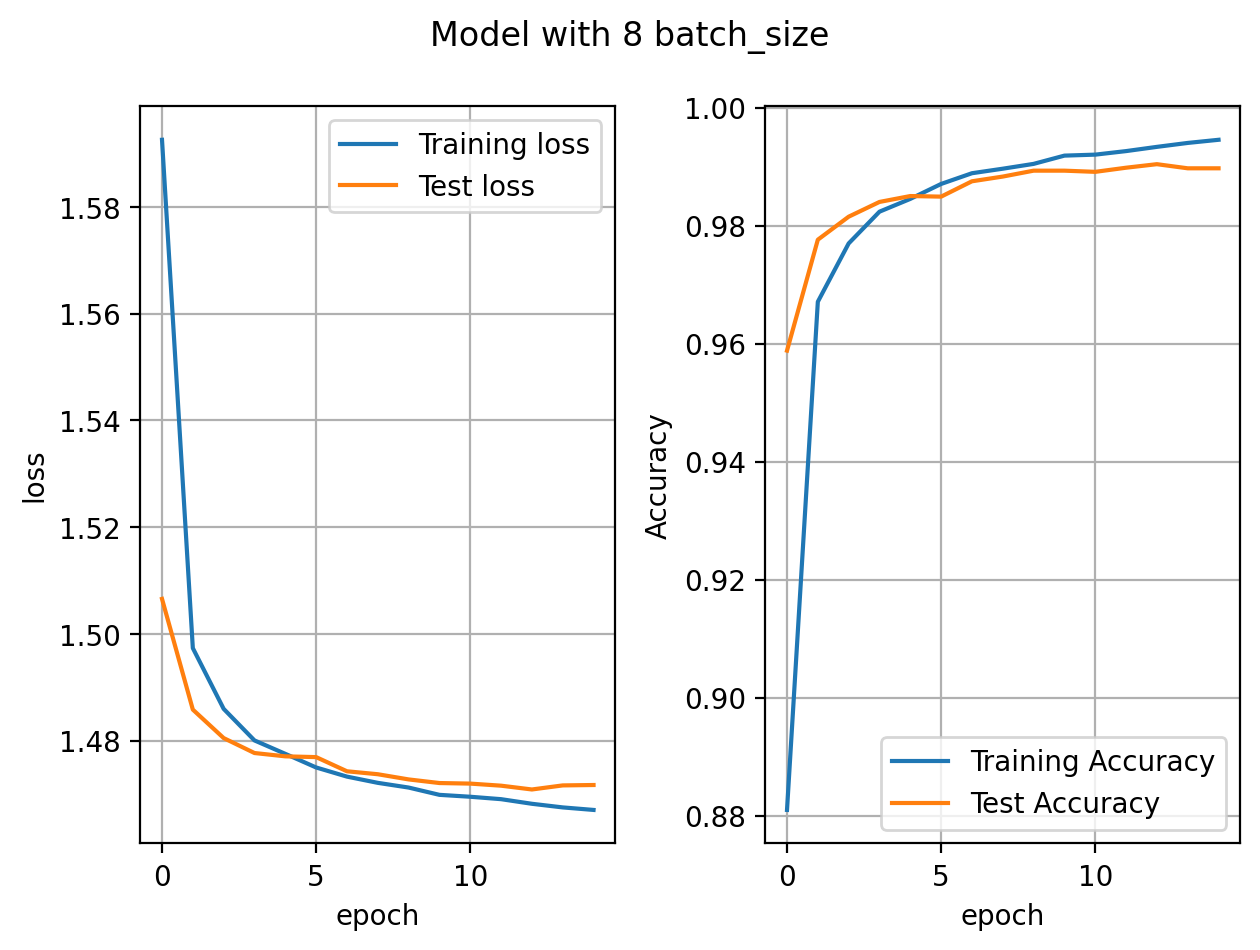

In [ ]:
plt.subplot(1,2,1)
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(accuracy_total_train, label='Training Accuracy')
plt.plot(accuracy_total_val, label='Test Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.suptitle(f'Model with 8 batch_size')
plt.tight_layout()
plt.show()

### Evaluating the Network Model with 8 batch_size

In [ ]:
img = images[0]
img = img.to(device)
img = img.view(-1, 1, 28, 28)
print(img.shape)

# Since we want to use the already pretrained weights to make some prediction
# we are turning off the gradients
with torch.no_grad():
    logits = model.forward(img)

torch.Size([1, 1, 28, 28])


[0.08533674 0.08533674 0.08533674 0.2319693  0.08533674 0.08533674
 0.08533674 0.08533674 0.08533674 0.08533674]


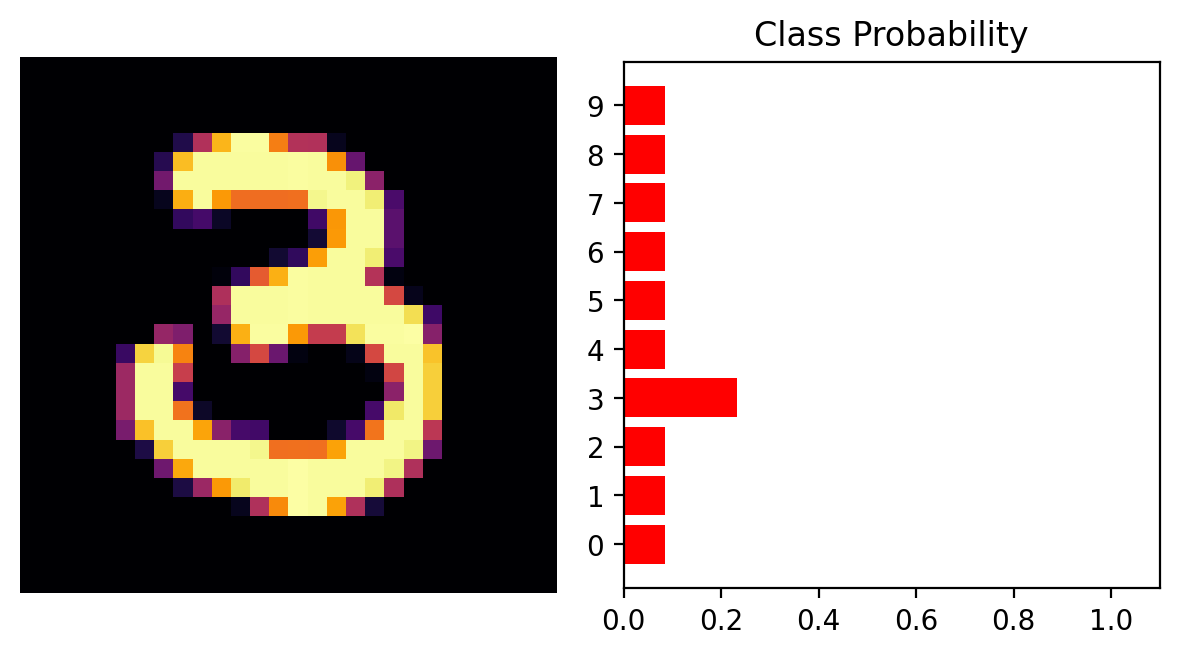

In [ ]:
#We take the softmax for probabilites since our outputs are logits
probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
ax1.imshow(img.view(1, 28, 28).detach().cpu().numpy().squeeze(), cmap='inferno')
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()

### Training and Testing the Model with 1 batch_size

In [ ]:
epochs = 15
train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_val = [], []

for epoch in range(epochs):

    total_train_loss = 0
    total_val_loss = 0

    model.train()

    total = 0
    # training our model
    for idx, (image, label) in enumerate(trainLoader_1): # 1, 8, 32, 50

        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()    # calc gradients
        optimizer.step()   # update gradients

        #pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_train = total / len(train_set)
    accuracy_total_train.append(accuracy_train)

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)

    # validating our model
    model.eval()
    total = 0
    for idx, (image, label) in enumerate(testLoader_1): # 1, 8, 32, 50
        image, label = image.cuda(), label.cuda()
        pred = model(image)
        loss = criterion(pred, label)
        total_val_loss += loss.item()

        #pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_val = total / len(test_set)
    accuracy_total_val.append(accuracy_val)

    total_val_loss = total_val_loss / (idx + 1)
    val_loss.append(total_val_loss)

    if epoch % 5 == 0:
      print("Epoch: {}/{}  ".format(epoch, epochs),
            "Training loss: {:.4f}  ".format(total_train_loss),
            "Testing loss: {:.4f}  ".format(total_val_loss),
            "Train accuracy: {:.4f}  ".format(accuracy_train),
            "Test accuracy: {:.4f}  ".format(accuracy_val))

Epoch: 0/15   Training loss: 1.5425   Testing loss: 1.4842   Train accuracy: 0.9229   Test accuracy: 0.9780  
Epoch: 5/15   Training loss: 1.4732   Testing loss: 1.4724   Train accuracy: 0.9883   Test accuracy: 0.9890  
Epoch: 10/15   Training loss: 1.4694   Testing loss: 1.4742   Train accuracy: 0.9917   Test accuracy: 0.9871  


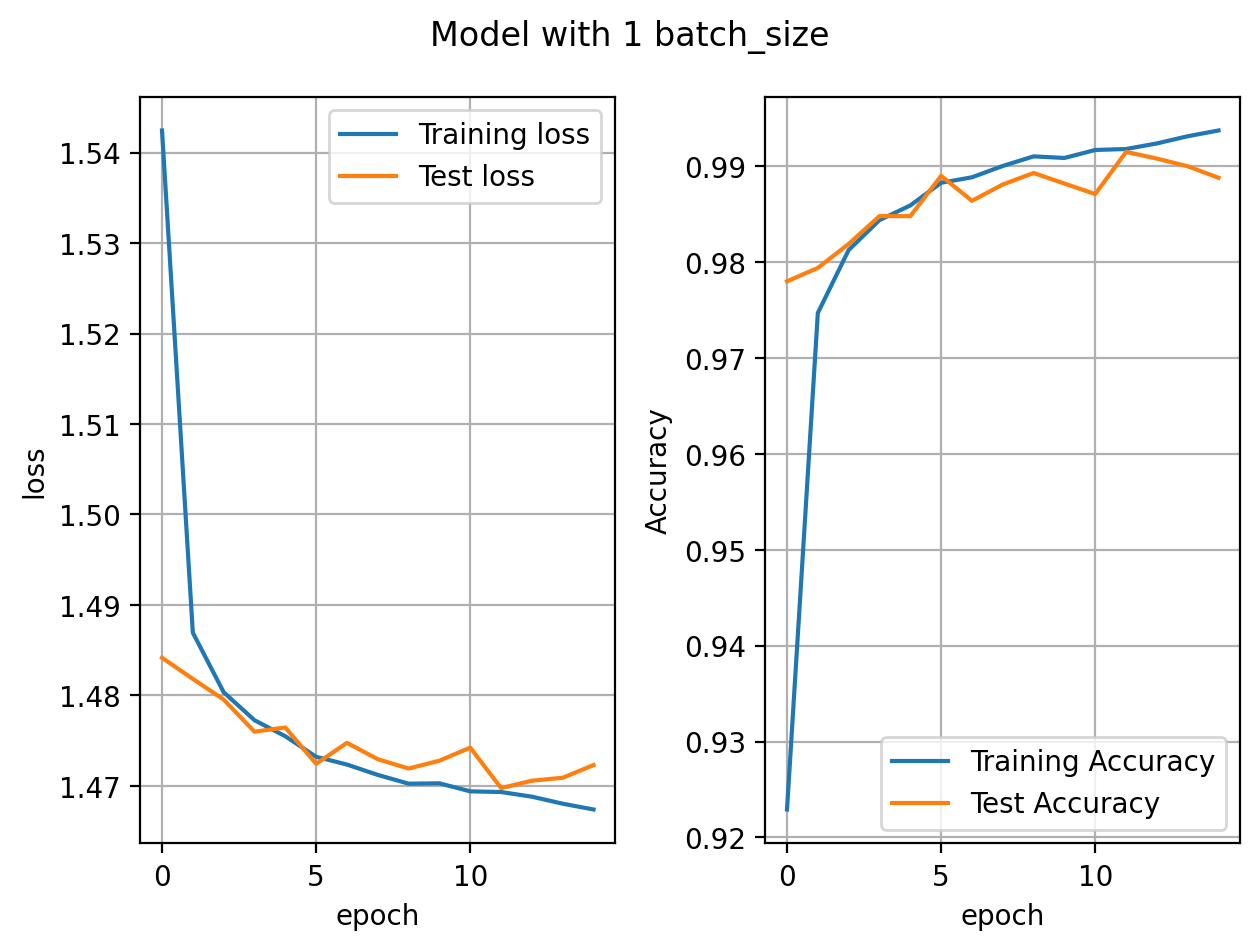

In [ ]:
plt.subplot(1,2,1)
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(accuracy_total_train, label='Training Accuracy')
plt.plot(accuracy_total_val, label='Test Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.suptitle(f'Model with 1 batch_size')
plt.tight_layout()
plt.show()

### Evaluating the Network Model with 1 batch_size

In [ ]:
img = images[0]
img = img.to(device)
img = img.view(-1, 1, 28, 28)
print(img.shape)

# Since we want to use the already pretrained weights to make some prediction
# we are turning off the gradients
with torch.no_grad():
    logits = model.forward(img)

torch.Size([1, 1, 28, 28])


[0.08533674 0.08533674 0.08533674 0.08533674 0.08533674 0.08533674
 0.08533674 0.08533674 0.08533674 0.2319693 ]


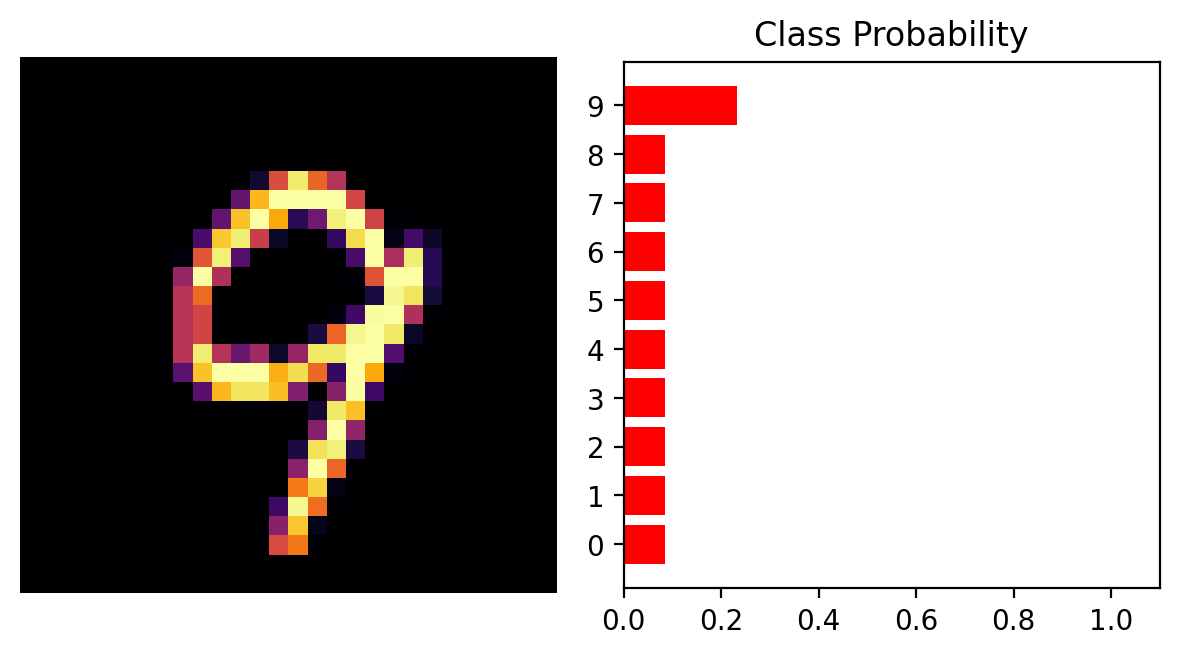

In [ ]:
#We take the softmax for probabilites since our outputs are logits
probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
ax1.imshow(img.view(1, 28, 28).detach().cpu().numpy().squeeze(), cmap='inferno')
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()